In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro,kstest,normaltest

import warnings
warnings.filterwarnings("ignore")

In [ ]:
 # To predict charges based on following features
# 'age', 'sex', 'bmi', 'children', 'smoker', 'region'

In [3]:
df = pd.read_csv("medical_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. EDA

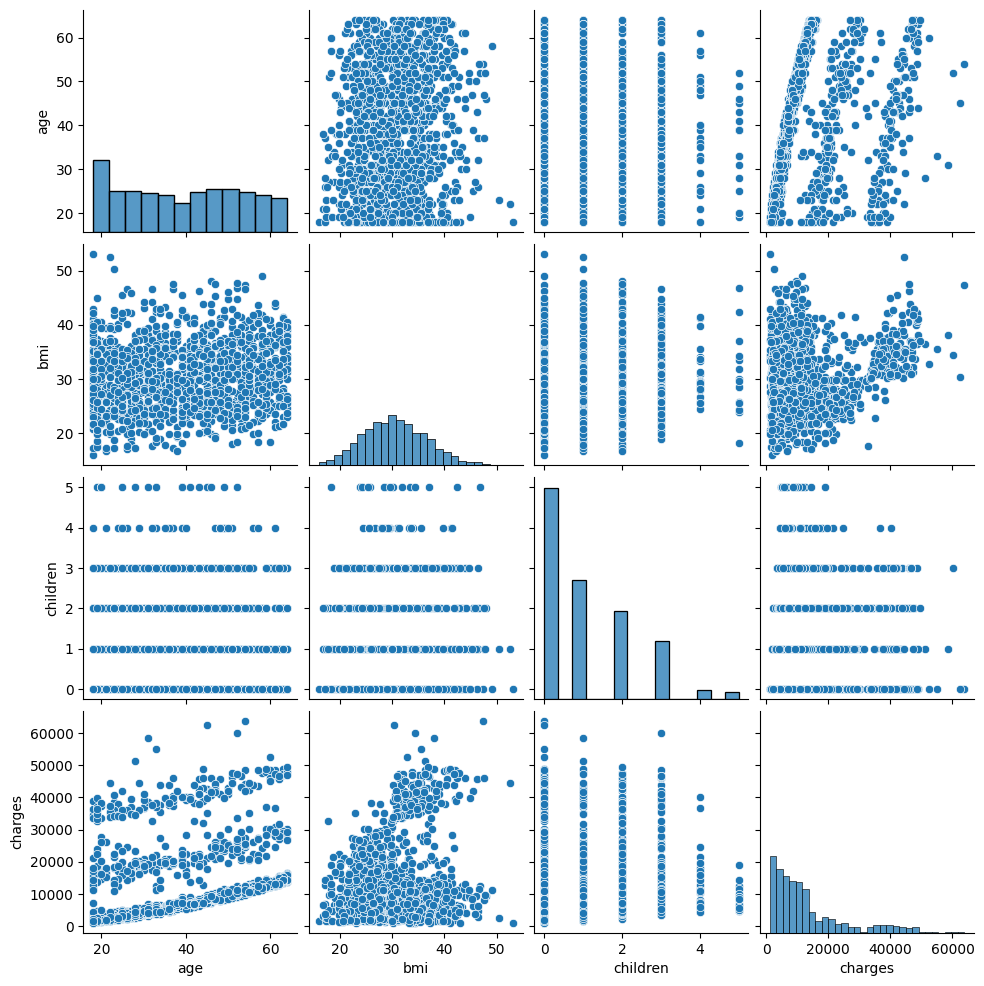

In [3]:
sns.pairplot(df)

<Axes: xlabel='age', ylabel='charges'>

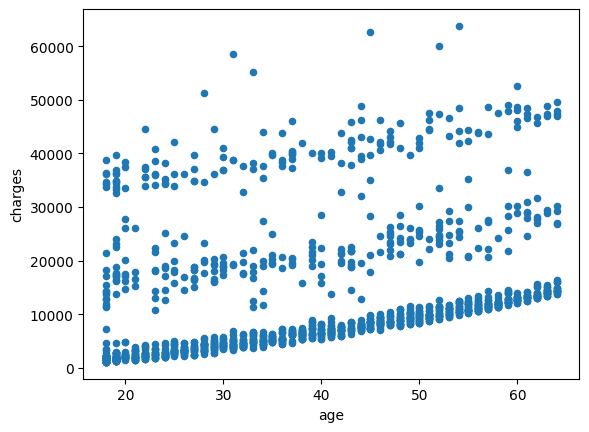

In [5]:
df.plot(x="age",y="charges", kind="scatter")


<Axes: xlabel='smoker', ylabel='charges'>

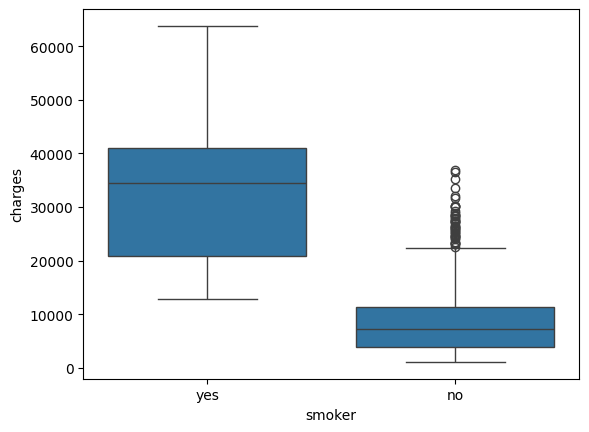

In [7]:
sns.boxplot(data=df,x = "smoker",y = "charges")

In [8]:
df[(df["smoker"] == "no") & (df["charges"] >=20000)]["age"].min()

np.int64(18)

In [9]:
df[(df["smoker"] == "no") & (df["charges"] >=20000)]["age"].max()

np.int64(64)

<Axes: xlabel='region', ylabel='charges'>

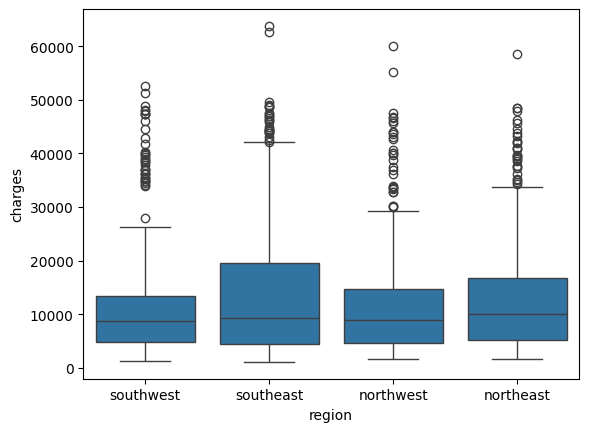

In [10]:
sns.boxplot(data=df,x = "region",y = "charges")

In [5]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## 4. Feture engineering

In [7]:
df1 = df.copy()

In [8]:
df1.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [9]:
df1 = pd.get_dummies(df1,columns=["region","smoker"])
df1.shape

(1338, 11)

In [12]:
df1[df1.duplicated()].shape

(1, 11)

In [13]:
df1.columns

Index(['age', 'sex', 'bmi', 'children', 'charges', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest', 'smoker_no',
       'smoker_yes'],
      dtype='object')

In [16]:
buckets = [0,18,30,45,60,np.inf] # 0 to 18 :  till 17
labels = [0,1,2,3,4]
df1["age_bucktes"] = pd.cut(df1["age"],bins=buckets,labels=labels,include_lowest=True,right = False)
df1["age_bucktes"] .value_counts()

age_bucktes
1    417
3    415
2    392
4    114
0      0
Name: count, dtype: int64

In [17]:
df1["risk"] = np.where(df1["age_bucktes"].isin([4]),1,0)
df1["risk"].value_counts()

risk
0    1224
1     114
Name: count, dtype: int64

In [19]:
df1["weight"] = df1["bmi"].apply(lambda x : 1 if x > 25 else 0)
df1["weight"].value_counts()

weight
1    1091
0     247
Name: count, dtype: int64

In [21]:
df1.drop(["age","bmi","sex"], axis=1, inplace=True)

In [22]:
df1.columns

Index(['children', 'charges', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'smoker_no', 'smoker_yes',
       'age_bucktes', 'risk', 'weight'],
      dtype='object')

## Model Training 

In [23]:
x = df1.drop("charges",axis=1)
y = df1.charges

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.8, random_state = 42)

In [27]:
knn_model = KNeighborsRegressor()
knn_model.fit(x_train,y_train)

KNeighborsRegressor()

In [28]:
std_scalar = StandardScaler()
std_scalar.fit(x_train)
array = std_scalar.transform(x_train)
std_train_df = pd.DataFrame(array,columns=x_train.columns)
std_train_df.head()

,children,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes,age_bucktes,risk,weight
0,0.734336,-0.576631,1.783168,-0.599661,-0.572314,0.508747,-0.508747,0.852323,-0.303046,-2.060364
1,-0.911192,1.734212,-0.560800,-0.599661,-0.572314,0.508747,-0.508747,0.852323,-0.303046,-2.060364
2,-0.911192,-0.576631,-0.560800,1.667609,-0.572314,0.508747,-0.508747,0.852323,-0.303046,-2.060364
3,3.202629,-0.576631,-0.560800,1.667609,-0.572314,0.508747,-0.508747,-0.184024,-0.303046,0.485351
4,1.557100,-0.576631,1.783168,-0.599661,-0.572314,0.508747,-0.508747,0.852323,-0.303046,-2.060364


In [29]:
knn_model = KNeighborsRegressor()
knn_model.fit(std_train_df,y_train)

KNeighborsRegressor()

#### Testing Data

In [30]:
array = std_scalar.transform(x_test)
std_test_df = pd.DataFrame(array,columns=x_test.columns)

In [31]:
y_pred_test = knn_model.predict(std_test_df)
mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error",mse) # scale varaient
rmse = np.sqrt(mse)
print("Root mean squared error",rmse)

r2_value_score = r2_score(y_test,y_pred_test)
print("R2 squared value",r2_value_score)

adj_r2_score = 1 - (((1-r2_value_score)* (x_test.shape[0]-1))/ (x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2_score)
# adj_r2 = 1 - ((1-R2)* (N-1))/(N-P-1)

Mean squared error 43323952.34677736
Root mean squared error 6582.093310397336
R2 squared value 0.7209384454837039
adjusted r2 score 0.7100800192379336


In [32]:
y_pred_train = knn_model.predict(std_train_df)
mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error",mse) # scale varaient
rmse = np.sqrt(mse)
print("Root mean squared error",rmse)

r2_value_score = r2_score(y_train,y_pred_train)
print("R2 squared value",r2_value_score)

adj_r2_score = 1 - (((1-r2_value_score)* (x_train.shape[0]-1))/ (x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2_score)
# adj_r2 = 1 - ((1-R2)* (N-1))/(N-P-1)

Mean squared error 30640190.464931928
Root mean squared error 5535.3582056567875
R2 squared value 0.7877127307237963
adjusted r2 score 0.7857081295030579


### 1) GridSearchCV() : search in grid
### 2) RandomizedSearchCV() : pick any random value

In [47]:
r2_train_list = []
r2_test_list = []
k_values = range(3,21)
for k in k_values:
    knn_reg = KNeighborsRegressor(n_neighbors=k,p=2)
    knn_reg.fit(std_train_df,y_train)
    ### training side
    r2_train = knn_reg.score(std_train_df,y_train)
    r2_train_list.append(r2_train)
       ### testing side
    r2_test = knn_reg.score(std_test_df,y_test)
    r2_test_list.append(r2_test)
    

Text(0, 0.5, 'ACCURACY')

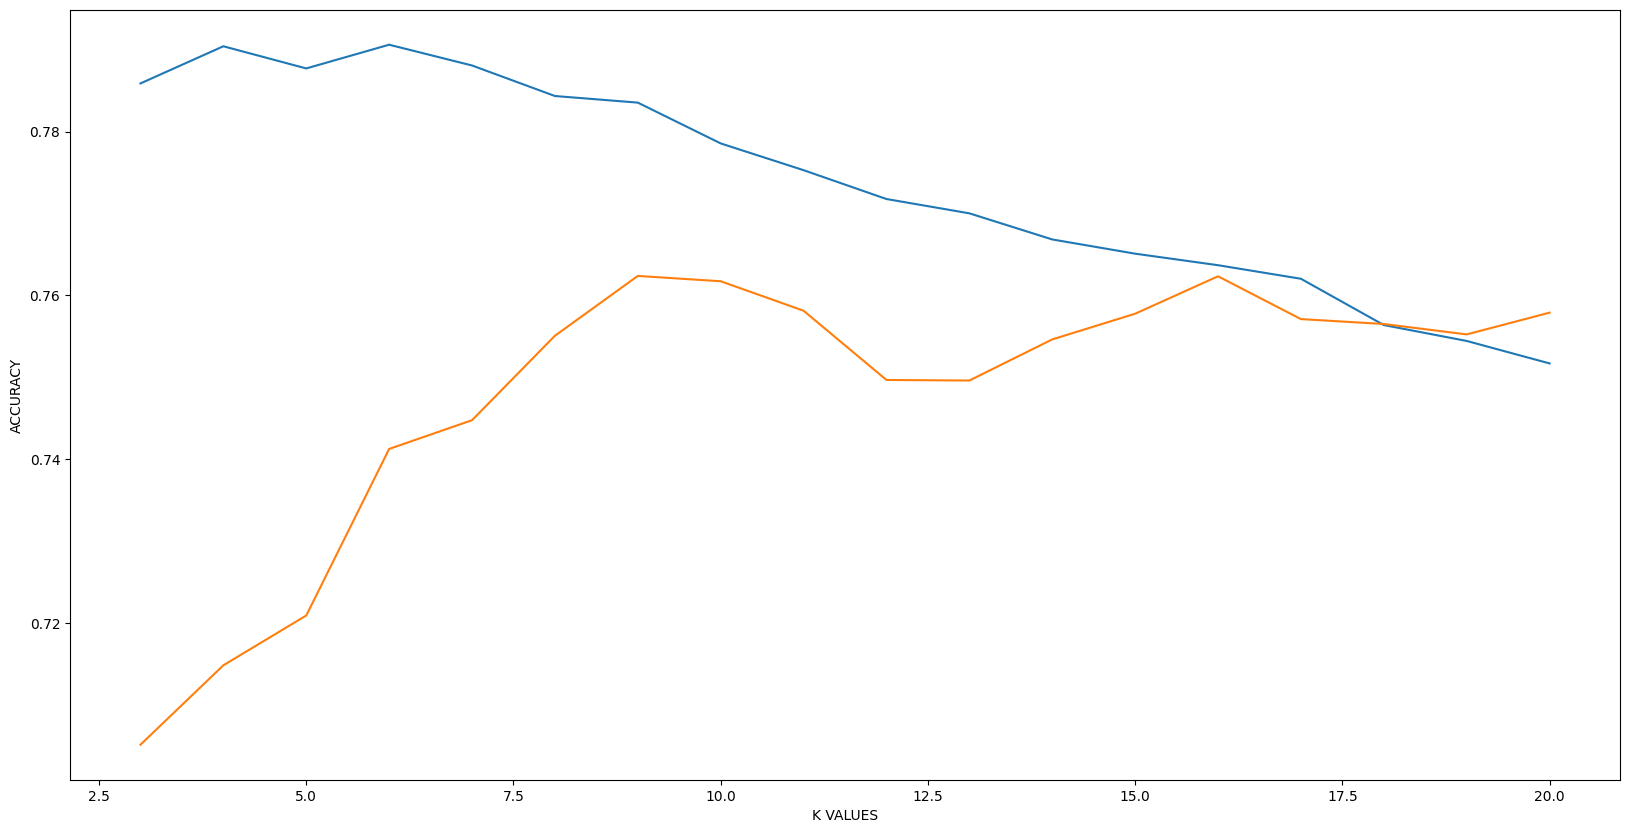

In [48]:
plt.figure(figsize=(20,10))
plt.plot(k_values,r2_train_list)
plt.plot(k_values,r2_test_list)
plt.xlabel("K VALUES")
plt.ylabel("ACCURACY")

In [36]:
r2_train_list = []
r2_test_list = []
k_values = range(3,21)
for k in k_values:
    knn_reg = KNeighborsRegressor(n_neighbors=k,p=1)
    knn_reg.fit(std_train_df,y_train)
    ### training side
    r2_train = knn_reg.score(std_train_df,y_train)
    r2_train_list.append(r2_train)
       ### testing side
    r2_test = knn_reg.score(std_test_df,y_test)
    r2_test_list.append(r2_test)

Text(0, 0.5, 'ACCURACY')

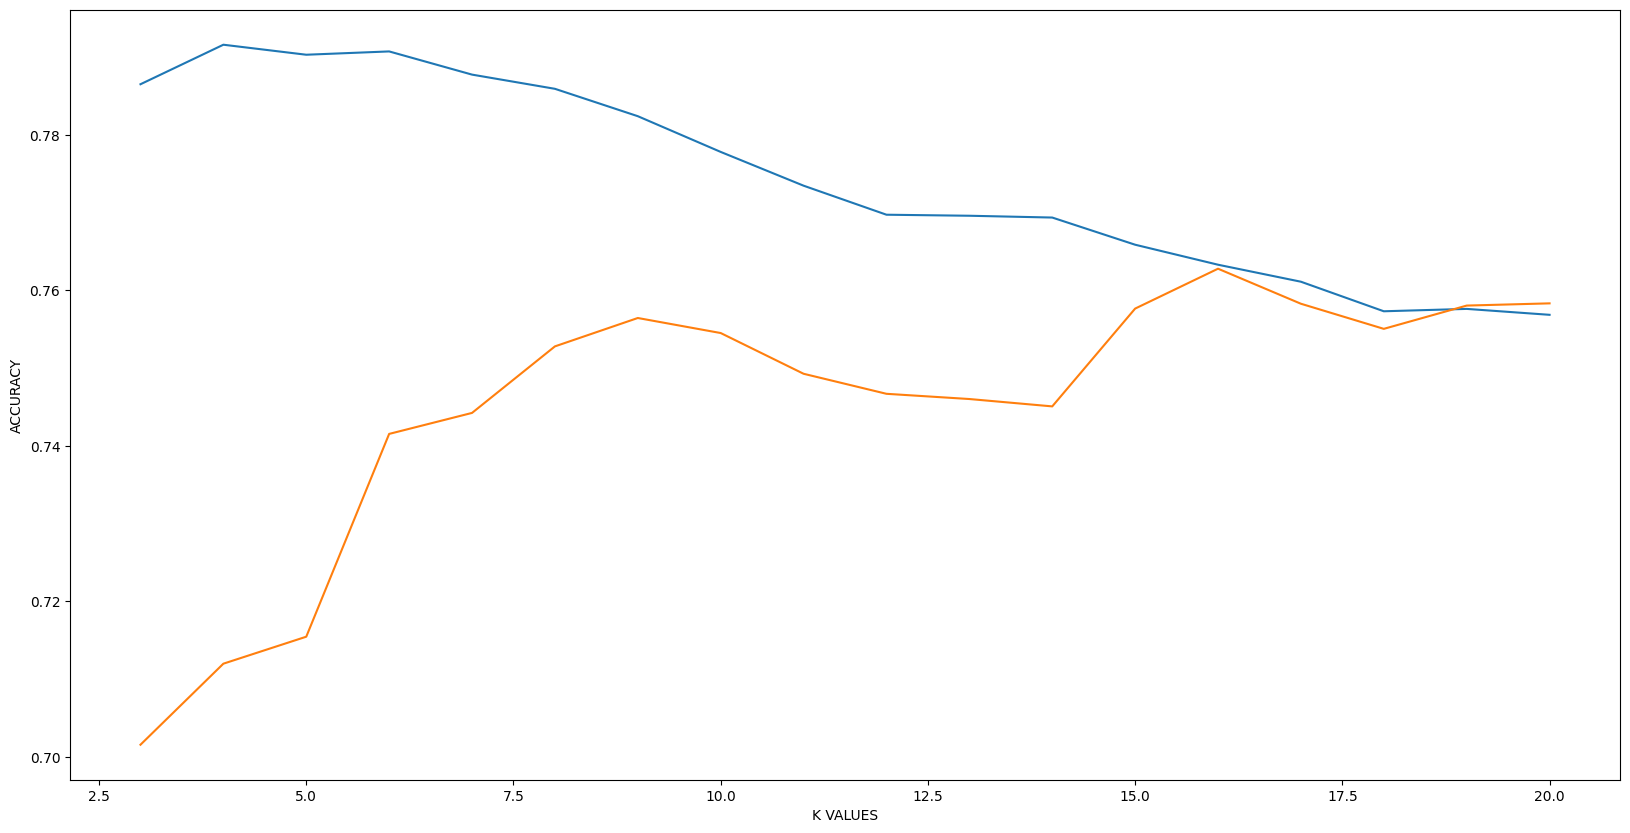

In [37]:
plt.figure(figsize=(20,10))
plt.plot(k_values,r2_train_list)
plt.plot(k_values,r2_test_list)
plt.xlabel("K VALUES")
plt.ylabel("ACCURACY")

In [38]:
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(std_train_df,y_train)

KNeighborsRegressor(n_neighbors=4)

In [39]:
y_pred_test = knn_model.predict(std_test_df)
mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error",mse) # scale varaient
rmse = np.sqrt(mse)
print("Root mean squared error",rmse)

r2_value_score = r2_score(y_test,y_pred_test)
print("R2 squared value",r2_value_score)

adj_r2_score = 1 - (((1-r2_value_score)* (x_test.shape[0]-1))/ (x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2_score)
# adj_r2 = 1 - ((1-R2)* (N-1))/(N-P-1)

Mean squared error 44267532.160064854
Root mean squared error 6653.385015168208
R2 squared value 0.71486058704183
adjusted r2 score 0.7037656682496833


In [40]:
y_pred_train = knn_model.predict(std_train_df)
mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error",mse) # scale varaient
rmse = np.sqrt(mse)
print("Root mean squared error",rmse)

r2_value_score = r2_score(y_train,y_pred_train)
print("R2 squared value",r2_value_score)

adj_r2_score = 1 - (((1-r2_value_score)* (x_train.shape[0]-1))/ (x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2_score)
# adj_r2 = 1 - ((1-R2)* (N-1))/(N-P-1)

Mean squared error 30249602.025842376
Root mean squared error 5499.963820412128
R2 squared value 0.7904188807798828
adjusted r2 score 0.7884398333840366


## Save Model

In [49]:
import pickle

In [50]:
with open("KNN_MODEL.pkl","wb") as file:
    pickle.dump(knn_model,file)

In [51]:
with open("scale.pkl","wb") as file:
    pickle.dump(std_scalar,file)

In [52]:
label_json = {"columns" : list(x.columns)}
label_json

{'columns': ['children',
  'region_northeast',
  'region_northwest',
  'region_southeast',
  'region_southwest',
  'smoker_no',
  'smoker_yes',
  'age_bucktes',
  'risk',
  'weight']}

In [53]:
import json

In [54]:
with open("label_encode.json","w") as file:
    json.dump(label_json,file)